# Updation of previous model with Adaptive Moment Estimation (Adam) optimizer

In [1]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam # Import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau # Import ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# MobileNetV2 is commonly trained on 224x224 images
height = 224
width = 224

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(height, width, 3))

In [3]:
# --- Data Loading and Augmentation ---
train_dir = "dataset/training"
validation_dir = "dataset/validation"
batch_size = 8

In [4]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, # Use MobileNetV2's preprocess_input
    rotation_range=90, # Data Augmentation
    horizontal_flip=True,
    vertical_flip=True
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(height, width),
    batch_size=batch_size
)

Found 2774 images belonging to 2 classes.


In [5]:
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 592 images belonging to 2 classes.


In [6]:
def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    # Freeze the layers of the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom top layers for classification
    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        x = Dense(fc, activation='relu')(x)
        x = Dropout(dropout)(x)

    predictions = Dense(num_classes, activation='softmax')(x)

    finetune_model = Model(inputs=base_model.input, outputs=predictions)
    return finetune_model

In [9]:
class_list = ['Real', 'Fake']
FC_Layers = [1024, 1024]
dropout = 0.5

finetune_model = build_finetune_model(
    base_model,
    dropout=dropout,
    fc_layers=FC_Layers,
    num_classes=len(class_list)
)

In [10]:
num_epochs = 20
num_train_images = 2774
num_validation_images = 592

In [11]:
# Callbacks for saving the best model and stopping early
checkpoint = ModelCheckpoint(
    "MobileNetV2_model_improved.h5", # Using a new name for the improved model
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch'
)
early = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=10, # Can be reduced as the scheduler will help
    verbose=1,
    mode="auto"
)

# We are using ReduceLROnPlateau, which will reduce the learning rate when a metric (validation_accuracy) has stopped improving.

In [12]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    verbose=1,
    min_lr=0.00001
)

# Compile the model with the Adam optimizer
optimizer = Adam(learning_rate=0.001)
finetune_model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizer,
    metrics=['accuracy']
)

callbacks = [checkpoint, early, reduce_lr]

In [13]:
import pickle

history = finetune_model.fit(
    train_generator,
    steps_per_epoch=num_train_images // batch_size,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=num_validation_images // batch_size, # Corrected validation_steps
    callbacks=callbacks # Use the new callbacks list
)

with open('mobilenetv2_adam_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

c:\Users\PRATYAOY SARKAR\FinalYrProject\myenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6373 - loss: 18.9052
Epoch 1: val_accuracy improved from None to 0.79561, saving model to MobileNetV2_model_improved.h5


346/346 ━━━━━━━━━━━━━━━━━━━━ 469s 1s/step - accuracy: 0.6866 - loss: 10.2723 - val_accuracy: 0.7956 - val_loss: 0.7533 - learning_rate: 0.0010
Epoch 2/20
  1/346 ━━━━━━━━━━━━━━━━━━━━ 6:36 1s/step - accuracy: 0.8750 - loss: 2.0636

c:\Users\PRATYAOY SARKAR\FinalYrProject\myenv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.79561 to 0.80068, saving model to MobileNetV2_model_improved.h5


346/346 ━━━━━━━━━━━━━━━━━━━━ 23s 63ms/step - accuracy: 0.8750 - loss: 2.0636 - val_accuracy: 0.8007 - val_loss: 0.7277 - learning_rate: 0.0010
Epoch 3/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7485 - loss: 1.3377
Epoch 3: val_accuracy improved from 0.80068 to 0.81250, saving model to MobileNetV2_model_improved.h5


346/346 ━━━━━━━━━━━━━━━━━━━━ 431s 1s/step - accuracy: 0.7589 - loss: 0.9790 - val_accuracy: 0.8125 - val_loss: 0.5816 - learning_rate: 0.0010
Epoch 4/20
  1/346 ━━━━━━━━━━━━━━━━━━━━ 7:14 1s/step - accuracy: 0.5000 - loss: 0.8198
Epoch 4: val_accuracy improved from 0.81250 to 0.81419, saving model to MobileNetV2_model_improved.h5


346/346 ━━━━━━━━━━━━━━━━━━━━ 25s 68ms/step - accuracy: 0.5000 - loss: 0.8198 - val_accuracy: 0.8142 - val_loss: 0.5799 - learning_rate: 0.0010
Epoch 5/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7597 - loss: 0.6075
Epoch 5: val_accuracy did not improve from 0.81419
346/346 ━━━━━━━━━━━━━━━━━━━━ 440s 1s/step - accuracy: 0.7516 - loss: 0.5939 - val_accuracy: 0.6166 - val_loss: 1.4192 - learning_rate: 0.0010
Epoch 6/20
  1/346 ━━━━━━━━━━━━━━━━━━━━ 6:22 1s/step - accuracy: 1.0000 - loss: 0.1524
Epoch 6: val_accuracy did not improve from 0.81419
346/346 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 1.0000 - loss: 0.1524 - val_accuracy: 0.6098 - val_loss: 1.5360 - learning_rate: 0.0010
Epoch 7/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7717 - loss: 0.5170
Epoch 7: val_accuracy improved from 0.81419 to 0.83615, saving model to MobileNetV2_model_improved.h5


346/346 ━━━━━━━━━━━━━━━━━━━━ 445s 1s/step - accuracy: 0.7726 - loss: 0.4977 - val_accuracy: 0.8361 - val_loss: 0.4732 - learning_rate: 0.0010
Epoch 8/20
  1/346 ━━━━━━━━━━━━━━━━━━━━ 8:41 2s/step - accuracy: 0.8750 - loss: 0.3261
Epoch 8: val_accuracy improved from 0.83615 to 0.83784, saving model to MobileNetV2_model_improved.h5


346/346 ━━━━━━━━━━━━━━━━━━━━ 30s 82ms/step - accuracy: 0.8750 - loss: 0.3261 - val_accuracy: 0.8378 - val_loss: 0.4759 - learning_rate: 0.0010
Epoch 9/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7822 - loss: 0.4577
Epoch 9: val_accuracy did not improve from 0.83784
346/346 ━━━━━━━━━━━━━━━━━━━━ 471s 1s/step - accuracy: 0.7722 - loss: 0.5315 - val_accuracy: 0.8345 - val_loss: 0.3856 - learning_rate: 0.0010
Epoch 10/20
  1/346 ━━━━━━━━━━━━━━━━━━━━ 7:21 1s/step - accuracy: 0.8750 - loss: 0.3167
Epoch 10: val_accuracy did not improve from 0.83784
346/346 ━━━━━━━━━━━━━━━━━━━━ 23s 64ms/step - accuracy: 0.8750 - loss: 0.3167 - val_accuracy: 0.8260 - val_loss: 0.4063 - learning_rate: 0.0010
Epoch 11/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7365 - loss: 0.5438
Epoch 11: val_accuracy improved from 0.83784 to 0.89527, saving model to MobileNetV2_model_improved.h5


346/346 ━━━━━━━━━━━━━━━━━━━━ 454s 1s/step - accuracy: 0.7404 - loss: 0.5304 - val_accuracy: 0.8953 - val_loss: 0.3368 - learning_rate: 0.0010
Epoch 12/20
  1/346 ━━━━━━━━━━━━━━━━━━━━ 8:40 2s/step - accuracy: 1.0000 - loss: 0.1935
Epoch 12: val_accuracy did not improve from 0.89527
346/346 ━━━━━━━━━━━━━━━━━━━━ 26s 70ms/step - accuracy: 1.0000 - loss: 0.1935 - val_accuracy: 0.8936 - val_loss: 0.3399 - learning_rate: 0.0010
Epoch 13/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7324 - loss: 0.4995
Epoch 13: val_accuracy did not improve from 0.89527
346/346 ━━━━━━━━━━━━━━━━━━━━ 1179s 3s/step - accuracy: 0.7462 - loss: 0.4802 - val_accuracy: 0.8294 - val_loss: 0.6624 - learning_rate: 0.0010
Epoch 14/20
  1/346 ━━━━━━━━━━━━━━━━━━━━ 7:12 1s/step - accuracy: 0.7500 - loss: 0.4946
Epoch 14: val_accuracy did not improve from 0.89527
346/346 ━━━━━━━━━━━━━━━━━━━━ 35s 98ms/step - accuracy: 0.7500 - loss: 0.4946 - val_accuracy: 0.8243 - val_loss: 0.6745 - learning_rate: 0.0010
Epoch 15/20

In [14]:
MODEL_PATH = "MobileNetV2_model_improved.h5" 

model = load_model(MODEL_PATH)
true_labels = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

predictions = model.predict(validation_generator)
predicted_labels = np.argmax(predictions, axis=1)


74/74 ━━━━━━━━━━━━━━━━━━━━ 26s 325ms/step


In [15]:
from sklearn.metrics import classification_report, accuracy_score

In [16]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Printing the final accuracy values
print(f"Final Training Accuracy: {train_acc[-1]:.4f}")
print(f"Final Validation Accuracy: {val_acc[-1]:.4f}")

Final Training Accuracy: 0.3750
Final Validation Accuracy: 0.8834


In [17]:
print("--- Model Evaluation Report ---")
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}\n")

# Print precision, recall, f1-score for each class
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_labels))

--- Model Evaluation Report ---
Accuracy: 0.8953

Classification Report:
              precision    recall  f1-score   support

        fake       0.88      0.92      0.90       296
        real       0.91      0.87      0.89       296

    accuracy                           0.90       592
   macro avg       0.90      0.90      0.90       592
weighted avg       0.90      0.90      0.90       592



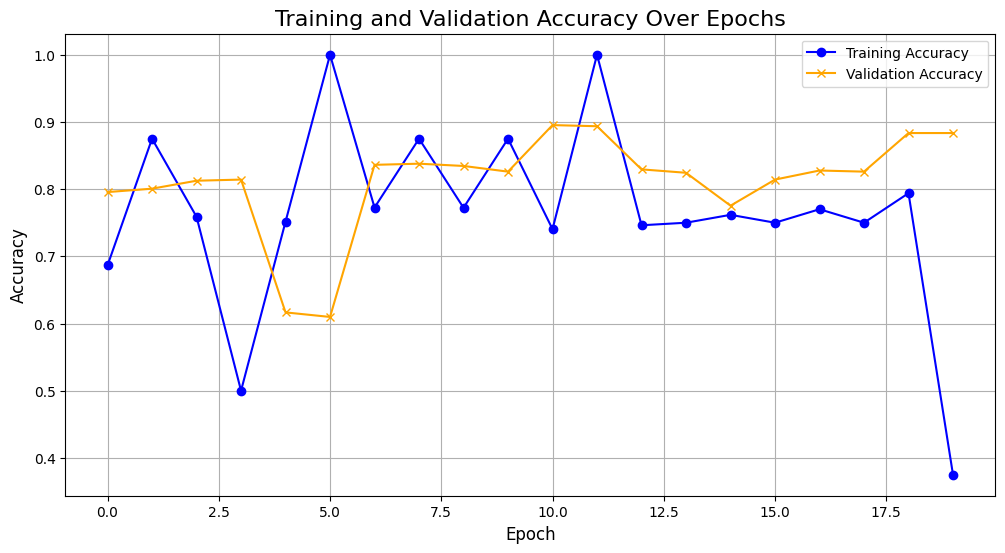

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(train_acc, label='Training Accuracy', color='blue', marker='o')
plt.plot(val_acc, label='Validation Accuracy', color='orange', marker='x')

# Adding titles and labels for clarity
plt.title('Training and Validation Accuracy Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='best')
plt.grid(True)

# Display the plot
plt.show()

In [19]:
from tensorflow.keras.models import load_model
model = load_model("MobileNetV2_model_improved.h5")

with open('mobilenetv2_adam_history.pkl', 'rb') as f:
    history_data = pickle.load(f)

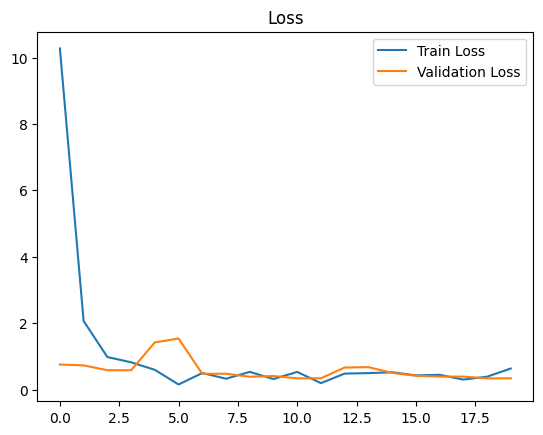

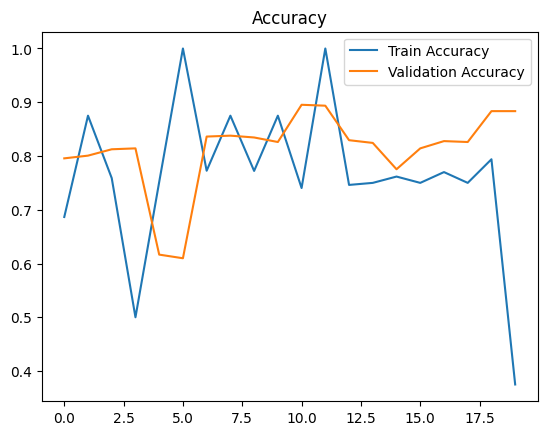

In [20]:
# Loss
plt.plot(history_data['loss'], label='Train Loss')
plt.plot(history_data['val_loss'], label='Validation Loss')
plt.title("Loss")
plt.legend()
plt.show()

# Accuracy
plt.plot(history_data['accuracy'], label='Train Accuracy')
plt.plot(history_data['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy")
plt.legend()
plt.show()

74/74 ━━━━━━━━━━━━━━━━━━━━ 23s 300ms/step


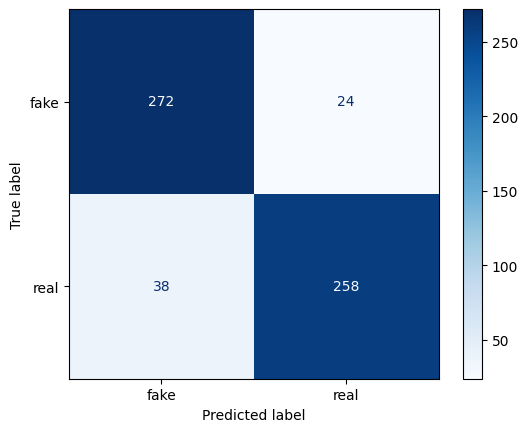

In [21]:
#Confusion Matrix
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = validation_generator.classes

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=validation_generator.class_indices)
disp.plot(cmap="Blues")
plt.show()


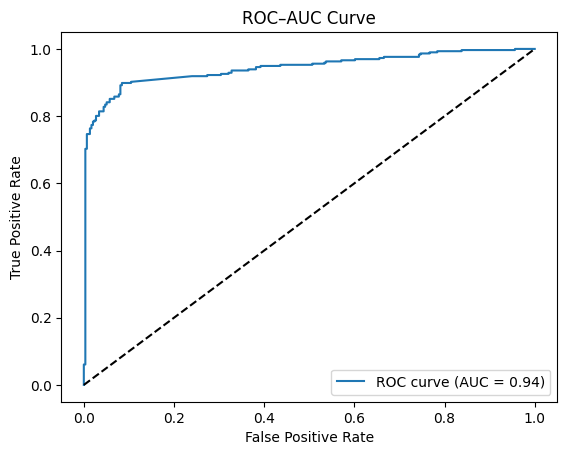

In [22]:
from sklearn.metrics import roc_curve, auc

# take probability of class 1 (real)
y_score = y_pred[:, 1]  
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC–AUC Curve")
plt.legend(loc="lower right")
plt.show()


In [ ]:
import tensorflow as tf
import numpy as np

img1_path = "dataset/testing/fake/aug_1399_WhatsApp Image 2025-04-05 at 10.59.15.jpeg"
img2_path = "dataset/testing/real/Screenshot 2025-02-11 144137_aug1.jpg"

def preprocess(img_path):
    img = tf.keras.utils.load_img(img_path, target_size=(224,224))
    arr = tf.keras.utils.img_to_array(img)
    arr = np.expand_dims(arr, axis=0) / 255.0
    return img, arr

img1, arr1 = preprocess(img1_path)
img2, arr2 = preprocess(img2_path)

pred1 = np.argmax(model.predict(arr1), axis=1)[0]
pred2 = np.argmax(model.predict(arr2), axis=1)[0]

labels = list(validation_generator.class_indices.keys())

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(img1)
plt.title(f"Predicted: {labels[pred1]}")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(img2)
plt.title(f"Predicted: {labels[pred2]}")
plt.axis("off")

plt.show()


NameError: name 'model' is not defined